In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore', category=FutureWarning)

### 9

In [3]:
# Load dataset
college = pd.read_csv('../../data/College.csv')
college.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [4]:
# Clean dataset and split into test/training
college = college.iloc[:,1:] # Drop 'Unnamed' column
college = pd.get_dummies(college) # Convert categorical variables to binary

y = college['Apps']
X = college.drop('Apps', axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [5]:
# Fit linear model using least squares
lm_reg = LinearRegression()
lm_model = lm_reg.fit(X_train,y_train)
lm_preds = lm_model.predict(X_test)
lm_score = mean_squared_error(y_test, lm_preds)
print(f'Mean Squared Error from Linear Regression: {lm_score}')

Mean Squared Error from Linear Regression: 1022430.0889255474


In [6]:
# Fit ridge regression using cross-val to select lambda
alphas = [0.01,0.1,1.0,10.0]
ridge_reg = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', cv =5)
ridge_model_cv = ridge_reg.fit(X_train,y_train)
ridge_model = Ridge(alpha = ridge_model_cv.alpha_).fit(X_train,y_train)
ridge_preds = ridge_model.predict(X_test)
ridge_score = mean_squared_error(y_test, ridge_preds)
print(f'Mean Squared Error from Ridge Regression: {ridge_score}')

Mean Squared Error from Ridge Regression: 1020512.03988358


In [7]:
# Fit Lasso regression using cross-val to select lambda
lasso_reg = LassoCV(alphas=alphas, cv=10, max_iter=10000)
lasso_model_cv = lasso_reg.fit(X_train,y_train)
lasso_model = Lasso(alpha = lasso_model_cv.alpha_).fit(X_train,y_train)
lasso_preds = lasso_model.predict(X_test)
lasso_score = mean_squared_error(y_test, lasso_preds)
print(f'Mean Squared Error from Lasso Regression: {lasso_score}')

# Report number of non-zero coefficients
pd.Series(lasso_model.coef_, index = X_train.columns) # 1 zero coefficient, 17 non-zero

Mean Squared Error from Lasso Regression: 1018742.2107344208


Accept           1.626053
Enroll          -1.039070
Top10perc       56.991507
Top25perc      -17.267190
F.Undergrad      0.076080
P.Undergrad      0.055430
Outstate        -0.082422
Room.Board       0.171550
Books            0.006365
Personal        -0.012855
PhD            -10.563513
Terminal        -2.434830
S.F.Ratio        4.560026
perc.alumni      0.210824
Expend           0.048030
Grad.Rate        8.090713
Private_No     431.070880
Private_Yes     -0.000000
dtype: float64

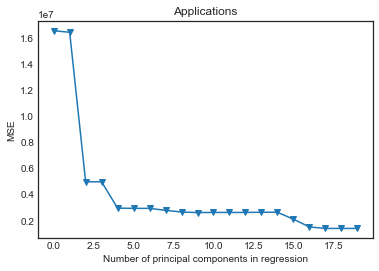

In [29]:
# Fit a PCR model with M chosen by cross-validation
pca = PCA()
X_train_reduced = pca.fit_transform(scale(X_train))

n = len(X_train_reduced)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*model_selection.cross_val_score(regr, X_train_reduced[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Applications')
plt.xlim(xmin=-1);

In [31]:
X_test_reduced = pca.transform(scale(X_test))[:,:17]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_train_reduced[:,:17], y_train)

# Prediction with test data
pca_preds = regr.predict(X_test_reduced)
pca_score = mean_squared_error(y_test, pca_preds)
print(f'Mean Squared Error from PCA Regression: {pca_score}')

Mean Squared Error from PCA Regression: 1903417.1863542295


(-1.0, 19.9)

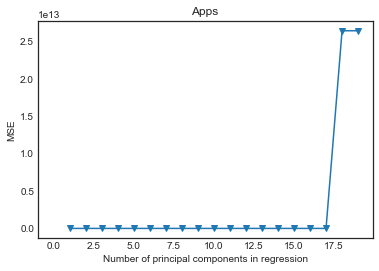

In [36]:
# Fit a PLS model with M chosen by cross-validation

n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Apps')
plt.xlim(xmin=-1)

In [38]:
pls = PLSRegression(n_components=12)
pls_model = pls.fit(scale(X_train), y_train)
pls_preds = pls.predict(scale(X_test))
pls_score = mean_squared_error(y_test, pls_preds)
print(f'Mean Squared Error from PLS Regression: {pls_score}')

Mean Squared Error from PLS Regression: 1903668.4954968006


### 11

In [42]:
# Load data and split into train-test
boston = pd.read_csv('../../data/Boston.csv')

X = boston.drop('crim', axis =1)
y = boston['crim']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

In [44]:
# Fit simple linear regression with no CV
lm = LinearRegression()
lm_model = lm.fit(X_train,y_train)
lm_preds = lm_model.predict(X_test)
lm_score = mean_squared_error(y_test, lm_preds)
print(f'Mean Squared Error from Linear Regression: {lm_score}')

Mean Squared Error from Linear Regression: 52.55389272005458


In [45]:
# Fit ridge regression with lambda determined by CV 
alphas = [0.01,0.1,1.0,10.0]
ridge_reg = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', cv =5)
ridge_model_cv = ridge_reg.fit(X_train,y_train)
ridge_model = Ridge(alpha = ridge_model_cv.alpha_).fit(X_train,y_train)
ridge_preds = ridge_model.predict(X_test)
ridge_score = mean_squared_error(y_test, ridge_preds)
print(f'Mean Squared Error from Ridge Regression: {ridge_score}')

Mean Squared Error from Ridge Regression: 52.902469650515705


In [46]:
# Fit Lasso regression using cross-val to select lambda
lasso_reg = LassoCV(alphas=alphas, cv=10, max_iter=10000)
lasso_model_cv = lasso_reg.fit(X_train,y_train)
lasso_model = Lasso(alpha = lasso_model_cv.alpha_).fit(X_train,y_train)
lasso_preds = lasso_model.predict(X_test)
lasso_score = mean_squared_error(y_test, lasso_preds)
print(f'Mean Squared Error from Lasso Regression: {lasso_score}')

# Report number of non-zero coefficients
pd.Series(lasso_model.coef_, index = X_train.columns) # 1 zero coefficient, 17 non-zero

Mean Squared Error from Lasso Regression: 52.3536540236176


zn         0.039325
indus     -0.108928
chas      -0.000000
nox       -0.000000
rm         0.702803
age       -0.017436
dis       -0.735894
rad        0.549838
tax       -0.003375
ptratio   -0.159076
black      0.001745
lstat      0.202389
medv      -0.181921
dtype: float64

In [47]:
# Update model with removing features that had a coefficient of 0 in lasso regressio
X_train = X_train.drop(['chas', 'nox'], axis=1)
X_test = X_test.drop(['chas', 'nox'], axis=1)

In [49]:
# Fit simple linear regression with no CV
lm = LinearRegression()
lm_model = lm.fit(X_train,y_train)
lm_preds = lm_model.predict(X_test)
lm_score = mean_squared_error(y_test, lm_preds)
print(f'Mean Squared Error from Linear Regression: {lm_score}')

Mean Squared Error from Linear Regression: 53.1439761790761


In [50]:
# Fit ridge regression with lambda determined by CV 
alphas = [0.01,0.1,1.0,10.0]
ridge_reg = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', cv =5)
ridge_model_cv = ridge_reg.fit(X_train,y_train)
ridge_model = Ridge(alpha = ridge_model_cv.alpha_).fit(X_train,y_train)
ridge_preds = ridge_model.predict(X_test)
ridge_score = mean_squared_error(y_test, ridge_preds)
print(f'Mean Squared Error from Ridge Regression: {ridge_score}')

Mean Squared Error from Ridge Regression: 52.949564060020094


In [51]:
# Fit Lasso regression using cross-val to select lambda
lasso_reg = LassoCV(alphas=alphas, cv=10, max_iter=10000)
lasso_model_cv = lasso_reg.fit(X_train,y_train)
lasso_model = Lasso(alpha = lasso_model_cv.alpha_).fit(X_train,y_train)
lasso_preds = lasso_model.predict(X_test)
lasso_score = mean_squared_error(y_test, lasso_preds)
print(f'Mean Squared Error from Lasso Regression: {lasso_score}')

# Report number of non-zero coefficients
pd.Series(lasso_model.coef_, index = X_train.columns) # 1 zero coefficient, 17 non-zero

Mean Squared Error from Lasso Regression: 52.353658807379766


zn         0.039325
indus     -0.108929
rm         0.702808
age       -0.017437
dis       -0.735893
rad        0.549834
tax       -0.003375
ptratio   -0.159075
black      0.001745
lstat      0.202390
medv      -0.181920
dtype: float64

In [52]:
# Create polynomial transformation with degree 2
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit polynomial linear regression
lm = LinearRegression()
lm_model = lm.fit(X_train_poly,y_train)
lm_preds = lm_model.predict(X_test_poly)
lm_score = mean_squared_error(y_test, lm_preds)
print(f'Mean Squared Error from Linear Regression: {lm_score}')

Mean Squared Error from Linear Regression: 33.87095743858155
